# Search space, CORESET and blind decoding of PDCCH channels in 5G Networks


The purpose of this tutorial is to simulate **PDCCH Blind Decoding**.

* In this tutorial, we assume that the  Base Station (BS) transimts DCI corresponding to a UE chosing an         aggregation level of 2.

* The number of PDCCH candidates that a UE has to search blindly is **[2,4,0,0,0]**.
  i.e., UE has to search blindly for 4 candidates of AL 2.

* The PDCCH occupies a specific number of REs according to its aggregation level (AL) chosen by Base Station     (BS).


* An AL is quantified in terms of the number of Control Channel Elements (CCE) that it occupies.


* Aggregation level of L  = L * 72 Resource Elements (REs) on a down link (DL) grid including DMRS of PDCCH.


* Possible PDCCH AL can be any value from the set {1,2,4,8,16}.


* For every CCE of 1 OFDM symbol (i.e 72 REs) 54 REs are reserved for PDCCH payload and remaining 18 are         reserved for PDCCH DMRS respectively. 54 + 18 = 72 and the ratio 54/18 = 3.


* PDCCH Aggregation level is chosen based on search space type and is either common search space (CSS) or UE specific search space (USS).


**Table of Contents**

* [Import Libraries](#Import-Libraries)
    - [Python Libraries](#Python-Libraries)
    - [5G Toolkit Libraries](#5G-Toolkit-Libraries)
* [Simulation Parameters](#Simulation-Parameters)
* [CORESET and Search Space Set Parameters](#CORESET-and-SearchSpaceSet)
* [Transmitter Side Processing](#Transmitter-Side-Processing)
* [Displaying Resource Grid](#Displaying-Resource-Grid)
* [Wireless Channel : CDL-A](#Wireless-Channel)
* [Receiver Side Processing and Blind Decoding of UE](#BlindDecoding-of-UE)


**Note:** 

- `1 CCE = 6 REGs = 6 RBs with 1 OFDM symbol  = 6*12 REs = 72 REs`

- `1 CCE = 6/(num of OFDM symbol) RBs. i.e.,` 
    - `For 3 OFDM symbol 1 CCE = 2 RBs = 2 * 12 * 3 = 24 * 3  = 72 REs.`
    - `For 2 OFDM symbol 1 CCE = 3 RBs = 3 * 12 * 2 = 36 * 2  = 72 REs.`
    - `For 1 OFDM symbol 1 CCE = 6 RBs = 6 * 12 * 1 = 72 * 1 = 72 REs.` 
 
- `1 REG = 1 RB with 1 OFDM symbol = 12 REs`

- `1 RB  = 12 SCs with any number of OFDM symbol = 12 REs with any number of OFDM symbol`

- `1 RE  = 1 SC with 1 OFDM symbol`


## Import Libraries

### Python Libraries

In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib widget
# %matplotlib inline
import matplotlib.pyplot  as plt
import matplotlib.patches as patches

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.PhysicalChannels   import PDCCH, PDCCHDecoder, PDCCHCandidateBlindDecoding
from toolkit5G.ResourceMapping    import ResourceMappingPDCCH, CORESET, SearchSpaceSet
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPDCCH
from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters

In [3]:
terrain          = "CDL-A"               # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9             # carrier frequency in Hz
mu               = 0                     # numerology
scs              = (2**mu)*(15*10**3)    # sub-carrier spacing
slotNumber       = 0                     # slot number. Note that number of slots per sub-frame of 1 ms is 2**mu
numRBs           = 270                   # max number of PRBs. Please don't change this. The simulation will break down
Bandwidth        = numRBs*scs  
nBSs             = 1                     # number of BSs 
nUEs             = 1                     # number of UEs 
bsArrayGeometry  = np.array([1,1,1,2,2])
ueArrayGeometry  = np.array([1,1,1,1,2])
Nt               = bsArrayGeometry.prod()
Nr               = ueArrayGeometry.prod()
rnti             = np.random.randint(1,65519+1)
nID              = np.random.randint(2**16)
nBatches         = 10                    # number of batches
nOFDMSymPerSlot  = 14                    # number of ofdm symbols per slot
nSCs             = numRBs*12             # max number of Sub-Carriers 

## CORESET and Search Space Set Parameters

In [4]:

frequencyDomainResources = np.array([1,1,1,1,1,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0], dtype = int) 

duration = 3

monitoringSymbolsWithinSlot = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype = int) 
startSymIndex               = np.nonzero(monitoringSymbolsWithinSlot)[0][0]

coresetID       = 1
cce_reg_Mapping = "interleaved" # CCE to REG mapping type
L               = 3             # REG-Bundle size
R               = 3             # Interleaver size
nshift          = 0             # cyclic-shift index after interleaving

coresetObj        = CORESET(duration,frequencyDomainResources)
coresetPRBIndices = coresetObj(cce_REG_MappingType = cce_reg_Mapping, 
                               reg_BundleSize=L, interleaverSize = R, shiftIndex = nshift)
coresetSize       = coresetObj.numCCESInCoreset


ssType                   = "USS"
AggLevel                 = 2                                 # Aggregation level
coresetSize              = coresetObj.numCCESInCoreset       # CORESET size in number of CCEs
numCandidatesPerAL       = np.array([2,4,0,0,0], dtype=int)  # number of pdcch candidates per Aggregation Level.
ssObj = SearchSpaceSet(numerology = mu, searchSpaceType = ssType, 
                       numCandidates = numCandidatesPerAL, coresetDuration = duration)


##############
# CCE indices
##############

M      = numCandidatesPerAL[int(np.log2(AggLevel))]    
ueCand = ssObj(AggLevel,rnti,coresetSize,slotNumber,coresetID)
ueCCEs = ueCand[np.random.randint(M)]

        
        
print("#####################################################################")        
print("Duration of CORESET:", duration)
print()
print("Frequency Domain Resources:", frequencyDomainResources)
print()
print("CORESET size in CCEs:", coresetObj.numCCESInCoreset)
print()
print("Monitoring Symbols With in a Slot:", monitoringSymbolsWithinSlot)
print()
print("CORESET Start symbol index:", startSymIndex)
print()
print("#####################################################################")
print("Candidates Corresponding to UE with a chosen Aggregation Level of " + str(AggLevel) + ":\n", ueCand)
print()
print("CCEs Corresponding to UE:\n", ueCCEs)

#####################################################################
Duration of CORESET: 3

Frequency Domain Resources: [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]

CORESET size in CCEs: 15

Monitoring Symbols With in a Slot: [0 0 1 0 0 0 0 0 0 0 0 0 0 0]

CORESET Start symbol index: 2

#####################################################################
Candidates Corresponding to UE with a chosen Aggregation Level of 2:
 [[10 11]
 [12 13]
 [ 2  3]
 [ 6  7]]

CCEs Corresponding to UE:
 [6 7]


## Transmitter Side Processing

In [5]:
numPDCCHSym  = int(54*AggLevel)  # number of PDCCH symbol
numPDCCHdmrs = int(18*AggLevel)  # number of PDCCH DMRS symbol
E            = numPDCCHSym*2     # number of target bits
Kmax         = 100               # max payload size in bits
K            = int(12 + np.random.randint(np.minimum(Kmax, E)-24, dtype = int)) # payload size in bits
dciBits      = np.random.randint(0, 2, [nBatches, K])

##############################################
# PDCCH chain and generation of  QPSK symbols
##############################################
pdcchObj = PDCCH(K, E, rnti, nID)
symb     = pdcchObj(dciBits) 


###################
# Resource Mappping
###################
rmObj   = ResourceMappingPDCCH(mu, frequencyDomainResources, duration, monitoringSymbolsWithinSlot)
resGrid = rmObj(symb, cce_reg_Mapping, L, R, nshift, slotNumber, nID, ueCCEs)

##############################################
# Loading resource grid in transmission grid
##############################################
Nfft       = 2**np.random.randint(np.ceil(np.log2(12*numRBs)), 13) # fft size
txGrid     = np.zeros(resGrid.shape[0:-1]+(Nfft,),dtype = np.complex64)
bwpOffset  = np.random.randint(Nfft - 12*numRBs)
txGrid[..., bwpOffset:bwpOffset+12*numRBs] = resGrid
#################################################
# Beamformed Grid. 
# Currently repeating across each antenna element
#################################################
Xf    = txGrid[...,np.newaxis].repeat(Nt, axis = -1)

print()
print(" BWP Offset: "+str(bwpOffset))
print()
print(" Transmission Grid Shape: "+str(txGrid.shape)) # (nBatches,nSymbols,nSCs) 
print()
print(" Beamformed Grid Shape: "+str(Xf.shape))       # (nBatches,nSymbols,nSCs,Nr)  


 BWP Offset: 27

 Transmission Grid Shape: (10, 14, 4096)

 Beamformed Grid Shape: (10, 14, 4096, 4)


In [13]:
resGrid.shape

(10, 14, 3240)

## Displaying Resource Grid

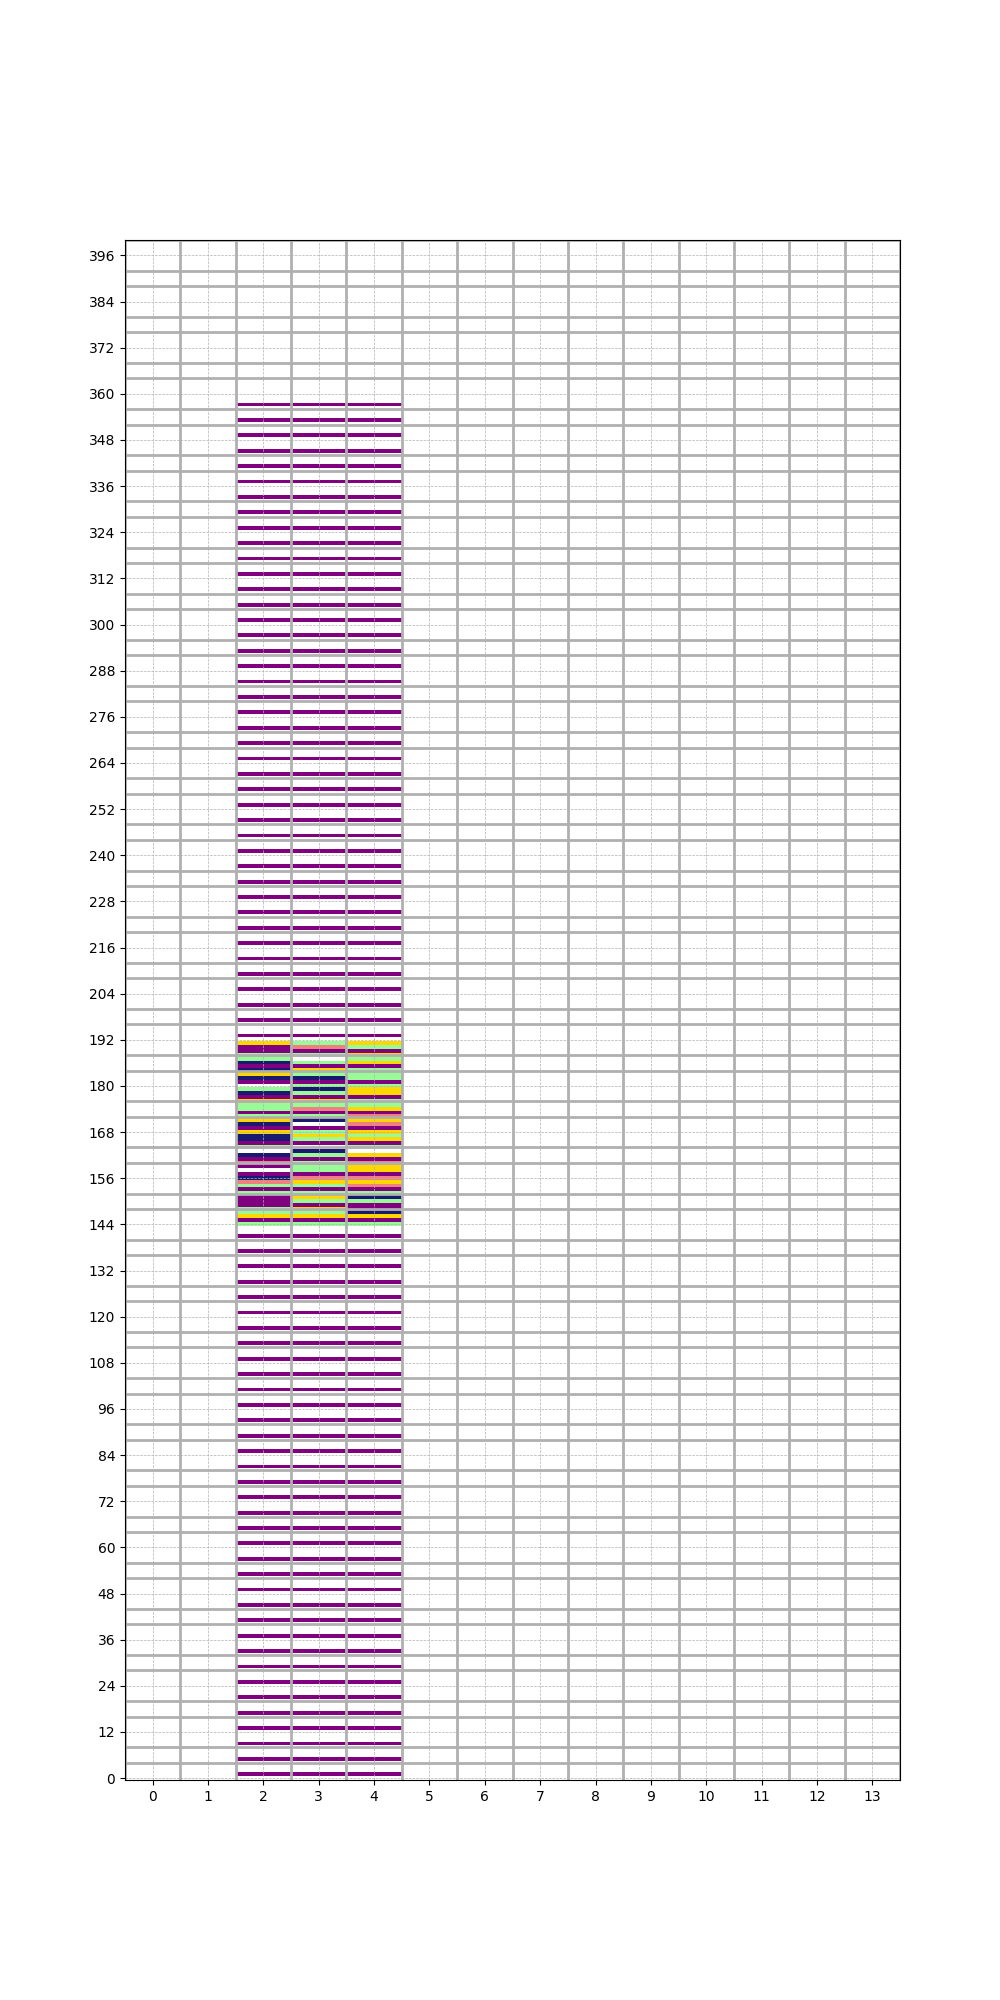

In [20]:
fig, ax = plt.subplots(figsize = (10,20))
colors  = ['white', 'palegreen', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [0,1,2,3,4,5,6]


cmap    = mpl.colors.ListedColormap(colors)
norm    = mpl.colors.BoundaryNorm(bounds, cmap.N)


Grid  = resGrid[...,0:400].sum(axis=0)

plt.imshow(np.abs(Grid.T), interpolation='none', aspect = "auto", cmap=cmap, norm=norm, origin='lower')

ax.set_xticks(np.arange(-0.5, Grid.shape[0],   1),  minor=True)
ax.set_xticks(np.arange(   0, Grid.shape[0],   1),  minor=False)
ax.set_yticks(np.arange(0, Grid.shape[1]+1, 4),  minor=True)
ax.set_yticks(np.arange(0, Grid.shape[1]+1, 12), minor=False)

ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')


plt.show()

## Wireless Channel : CDL-A

In [7]:
##########################
# Antenna Array at UE side
##########################
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, 
                           arrayStructure  = ueArrayGeometry)
ueAntArray() 

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()

##########################
# Antenna Array at BS side
##########################
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, 
                           arrayStructure  = bsArrayGeometry)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

####################
# Layout Parameters
####################
isd                  = 200         # inter site distance
minDist              = 10          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 1           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                minUEBSDistance = minDist,
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = terrain, carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray, bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject  = widthOfIndoorObject, forceLOS = forceLOS)



paramGen = simLayoutObj.getParameterGenerator()

##############################
# MIMO OFDM channel generation
##############################
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft, normalizeChannel = True)[0,0,0]

print()
print(" Hf shape: "+str(Hf.shape)) #(nUEs,Nfft, Nr, Nt) 
print()
print(" Xf shape: "+str(Xf.shape)) # (numBatches, numSym, nSCs, Nt)


 Hf shape: (1, 4096, 2, 4)

 Xf shape: (10, 14, 4096, 4)


## Receiver Side Processing and Blind Decoding of UE

In [8]:
#########################
# SNR for Blind Decoding
########################
snrdB   = 10  
snrBD   = 10**(snrdB/10)

################################
# Received Grid and Equalization
################################
# Output of channel
Y  = ((Hf[:,np.newaxis,np.newaxis,...]@Xf[np.newaxis,...,np.newaxis])[...,0])[0]
# Reshaped channel 
Hp = ((Hf.sum(axis = -1).transpose(0,2,1)[:,:,bwpOffset:bwpOffset+12*numRBs])[0]).sum(axis=0)[np.newaxis,np.newaxis,:]
# Added noise
Yf     = AddNoise(False)(Y, 1/snrBD, 0)
# received grid and Equalization
rxGrid = Yf[...,bwpOffset:bwpOffset+12*numRBs,:]
equalizedGrid    =  rxGrid.sum(axis=-1)/Hp


#########################
# Intiate Blind Decoding 
#########################
bdObj  = PDCCHCandidateBlindDecoding(coresetPRBIndices, duration, startSymIndex, 
                                      ssType, AggLevel ,ueCand)
bdObj(equalizedGrid, K, E, snrBD, rnti, nID, decoderType="SC", demappingMethod="app")
print("##########################################################################")
print()


------------------------------------------------------------------------------------------
Checking the CRC:
 [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
Blind Decoding UnSuccessful for CCE Indices  [10 11]..!Re-running the script by choosing different candidate
**********************************************************************************************
------------------------------------------------------------------------------------------
Checking the CRC:
 [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
Blind Decoding UnSuccessful for CCE Indices  [12 13]..!Re-running the script by choosing different candidate
**********************************************************************************************
------------------------------------------------------------------------------------------
Checking the CRC:
 [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]